<a href="https://colab.research.google.com/github/Tikquuss/word_embeddings/blob/main/Word2Vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Word2Vec**

Word2vec is a group of related models that are used to produce word embeddings.Word2vec takes as its input a large corpus of text and produces a vector space, typically of several hundred dimensions, with each unique word in the corpus being assigned a corresponding vector in the space. Word vectors are positioned in the vector space such that words that share common contexts in the corpus are located close to one another in the space.

- ***Continuous Bag of Words (CBOW)*** : In the continuous bag-of-words architecture, the model predicts the current word from a window of surrounding context words. The order of context words does not influence prediction (bag-of-words assumption). 

- ***Continuous Skipgram (CS)*** : In the continuous skip-gram architecture, the model uses the current word to predict the surrounding window of context words. The skip-gram architecture weighs nearby context words more heavily than more distant context words. This other architecture tries to guess neighboring words using the current word. 

According to the authors, CBOW is faster while skip-gram is slower but does a better job for infrequent words.

For a sentence $x = x_1 ... x_T$, we want to maximize the given likelihood :

$$\mathcal{L} (\theta) = \prod_{t=1}^{T} \prod_{-m \le j \le m } f_{\theta}(w_t, w_{t+j})$$

where :

$$
f_{\theta}(w_i, w_j) = \left\{
    \begin{array}{ll}
        P_{\theta} (w_i | w_j) & \mbox{for CBOW} \\
        P_{\theta} (w_j | w_i) & \mbox{for CS}
    \end{array}
\right.
$$

Hence, our objective function can be the average negative log likelihood :
$$\mathcal{J} (\theta) = - \frac{1}{T} log(\mathcal{L} (\theta)) = - \frac{1}{T} \sum_{t=1}^{T} \sum_{-m \le j \le m } f_{\theta}(w_t, w_{t+j})$$


**Model**

For each word $w$, we define two different vector representation $v_w$ and $u_w$ :
- $v_w$ is used when $w$ is a center word
- $u_w$ is used when $w$ is a context word

Hence, for a center word $c$ and a context word $o$ :

$P_{\theta} (o | c) = \frac{e^{u_o^Tv_c}}{\sum_{w \in V} e^{u_w^Tv_c}}$

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
def get_data(corpus, vocab = None, context_size = 10) :
    token_text = word_tokenize(corpus)
    pads = ["__pad__"]*context_size
    token_text = pads + token_text + pads
    len_token_text = len(token_text)

    print("# of tokens: ", len(token_text), '\n', token_text[context_size:10+context_size])

    # set of vocab items
    if vocab is None :
        vocab = set(token_text)

    data = []

    for i in range(context_size, len(token_text) - context_size):
        context = [token_text[j] for j in range(i - context_size, i + context_size + 1)]
        target = token_text[i]
        data.append((context, target))

    return data, vocab, len_token_text

In [ ]:
class CBOW(nn.Module):
    
    def __init__(self, vocab : set, len_token_text : int, data, embedding_dim = 2, hidden_dim = 128, batch_size = 32):
        super(CBOW, self).__init__()

        self.len_token_text = len_token_text
        unk = "unk"
        vocab = {unk}.union(vocab)
        self.vocab = vocab
        vocab_size = len(vocab)
        self.vocab_size = vocab_size
        self.word_to_idx = {word: i for i, word in enumerate(vocab)}
        self.idx_to_word = {i: word for i, word in enumerate(vocab)}
        self.unk_id = self.word_to_idx["unk"]

        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.proj = nn.Linear(embedding_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, vocab_size)

        self.data = data
        self.n_samples = len(data)
        self.batch_size = batch_size
        self.index = 0
        
    def forward(self, inputs):
        embeds = sum(self.embeddings(inputs)).view(1, -1)
        out = F.relu(self.proj(embeds))
        out = self.output(out)
        nll_prob = F.log_softmax(out, dim=-1)
        return nll_prob

    #def embeddings(self):
    #    # "we choose to use the sum W + W_tilde as our word vectors"
    #    pass
    
    def make_context_vector(self, context):
        idxs = [self.word_to_idx.get(w, self.unk_id) for w in context]
        return torch.tensor(idxs, dtype=torch.long)

    # Batch sampling function
    def gen_batch(self):
        if self.n_samples > self.index :
            self.index = 0
        self.index += self.batch_size
        return self.data[self.index - self.batch_size, self.index]
    
    def train(self, num_epochs, optimizer, loss_function = nn.NLLLoss()):
        """trains the model over num_epochs epochs, with the optimizer specified in the parameters."""
        
        losses = []
        #num_batches = int(self.len_token_text/self.batch_size)
        for epoch in range(num_epochs):
            total_loss = 0
            print("Beginning epoch %d" %epoch)
            #for batch in tqdm(range(num_batches)) :
            for context, target in self.data :
                context_vector = self.make_context_vector(context)
                self.zero_grad()
                nll_prob = self.__call__(context_vector)
                loss = loss_function(nll_prob, Variable(torch.tensor([self.word_to_idx[target]])))
                loss.backward()
                optimizer.step() 
                
                total_loss += loss.item()
              
            losses.append(total_loss)

            print('Epoch : %d, mean loss : %.02f, loss : %.02f' % (epoch, np.mean(losses), total_loss))
            print()

        return losses 

    def predict(self, sentence) :
        """
        returns the embedding that belongs to the given sentence (str)
        """
        sentence = sentence.lower()
        tokens = word_tokenize(sentence)
        token_ids = [self.word_to_idx.get(word, self.unk_id) for word in tokens]
        return self.embeddings.weight.data[token_ids]

    def get_context(self, context) :
        context_vector = self.make_context_vector(context)
        nll_prob = model(context_vector).data.numpy()
        max_idx = np.argmax(nll_prob)
        return self.idx_to_word[max_idx]

In [ ]:
# Plot loss fn
def plot_loss_fn(losses, title):
    plt.plot(range(len(losses)), losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(title)
    plt.figure()

def get_word(model, word):
    """
    returns the embedding that belongs to the given word (str)
    """
    return model.predict(word).squeeze()

def closest(model, vec, n = 10):
    """
    finds the closest words for a given vector
    """
    all_dists = [(w, torch.dist(vec, get_word(model, w))) for w in model.word_to_idx]
    return sorted(all_dists, key=lambda t: t[1])[:n]

# some helper fn
def print_tuples(tuples):
    for tuple in tuples:
        print('(%.4f) %s' % (tuple[1], tuple[0]))

# word analogies in the form w1 : w2 :: w3 : ?
def analogy(model, w1, w2, w3, n=5, filter_given=True):
    print('\n[%s : %s :: %s : ?]' % (w1, w2, w3))
   
    # w2 - w1 + w3 = w4
    closest_words = closest(model, get_word(model, w2) - get_word(model, w1) + get_word(model, w3))
    
    # Optionally filter out given words
    if filter_given:
        closest_words = [t for t in closest_words if t[0] not in [w1, w2, w3]]
        
    print_tuples(closest_words[:n])



---



In [ ]:
! git clone https://github.com/balazs-vida/glove-pytorch

Cloning into 'glove-pytorch'...
remote: Enumerating objects: 13, done.
remote: Total 13 (delta 0), reused 0 (delta 0), pack-reused 13
Unpacking objects: 100% (13/13), done.


In [ ]:
txt_file = "/content/glove-pytorch/short_story.txt"

# Open and read in text
with open(txt_file, 'r') as f :
    corpus = f.read().lower()

In [ ]:
CONTEXT_SIZE = 10
data, vocab, len_token_text = get_data(corpus, vocab = None, context_size = CONTEXT_SIZE)

print(data[:3])

# of tokens:  5546 
 ['the', 'last', 'question', 'was', 'asked', 'for', 'the', 'first', 'time', ',']
[(['__pad__', '__pad__', '__pad__', '__pad__', '__pad__', '__pad__', '__pad__', '__pad__', '__pad__', '__pad__', 'the', 'last', 'question', 'was', 'asked', 'for', 'the', 'first', 'time', ',', 'half'], 'the'), (['__pad__', '__pad__', '__pad__', '__pad__', '__pad__', '__pad__', '__pad__', '__pad__', '__pad__', 'the', 'last', 'question', 'was', 'asked', 'for', 'the', 'first', 'time', ',', 'half', 'in'], 'last'), (['__pad__', '__pad__', '__pad__', '__pad__', '__pad__', '__pad__', '__pad__', '__pad__', 'the', 'last', 'question', 'was', 'asked', 'for', 'the', 'first', 'time', ',', 'half', 'in', 'jest'], 'question')]


In [ ]:
model = CBOW(vocab, len_token_text, data, embedding_dim = 2, hidden_dim = 128, batch_size = 64)

In [ ]:
LEARNING_RATE = 0.001
optimizer = optim.SGD(model.parameters(), lr = LEARNING_RATE)

In [ ]:
EPOCHS = 10
losses = model.train(num_epochs = EPOCHS, optimizer = optimizer, loss_function = nn.NLLLoss())

Beginning epoch 0
Epoch : 0, mean loss : 34634.34, loss : 34634.34

Beginning epoch 1
Epoch : 1, mean loss : 33528.67, loss : 32423.01

Beginning epoch 2
Epoch : 2, mean loss : 32934.65, loss : 31746.60

Beginning epoch 3
Epoch : 3, mean loss : 32527.60, loss : 31306.47

Beginning epoch 4
Epoch : 4, mean loss : 32219.19, loss : 30985.52

Beginning epoch 5
Epoch : 5, mean loss : 31971.93, loss : 30735.64

Beginning epoch 6
Epoch : 6, mean loss : 31766.54, loss : 30534.18

Beginning epoch 7
Epoch : 7, mean loss : 31591.57, loss : 30366.83

Beginning epoch 8
Epoch : 8, mean loss : 31439.81, loss : 30225.69

Beginning epoch 9
Epoch : 9, mean loss : 31306.10, loss : 30102.74



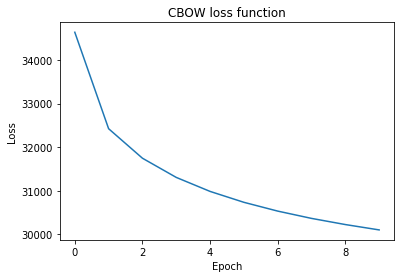

<Figure size 432x288 with 0 Axes>

In [ ]:
plot_loss_fn(losses, "CBOW loss function")

In [ ]:
context = ['process','Computational','are', 'abstract']
model.get_context(context)

'.'

In [ ]:
sentence = "unk1 Hello world unk2"
vec = model.predict(sentence)
print(vec.shape)
vec

torch.Size([4, 2])


tensor([[-0.1774, -0.1825],
        [-0.1774, -0.1825],
        [-0.3051,  1.5307],
        [-0.1774, -0.1825]])

In [ ]:
word = "time"
vector = get_word(model, word)
vector

tensor([1.5470, 1.4468])

In [ ]:
closest(model, vector)

[('time', tensor(0.)),
 ('runs', tensor(0.0892)),
 ('good', tensor(0.2271)),
 ('dim', tensor(0.2347)),
 ("'ve", tensor(0.2815)),
 ('moment', tensor(0.2870)),
 ('vacation', tensor(0.3475)),
 ('best', tensor(0.3638)),
 ('promptly', tensor(0.3912)),
 ('thing', tensor(0.4009))]

In [ ]:
analogy(model, "when", "time", "who")


[when : time :: who : ?]
(0.1110) fundamentally
(0.1525) shower
(0.1738) ash
(0.2062) never
(0.2235) read


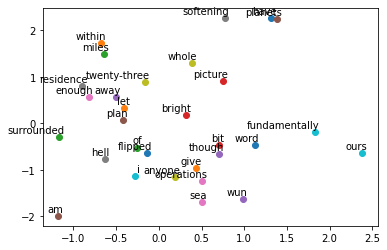

In [ ]:
N_WORDS = 30
# Visualize embeddings
#if EMBEDDING_SIZE == 2:
if True :
  # Pick some random words
	word_inds = np.random.choice(np.arange(len(vocab)), size = N_WORDS, replace=False)
	for word_ind in word_inds:
		w_embed = model.embeddings.weight.data[word_ind].numpy()
		x, y = w_embed[0], w_embed[1]
		plt.scatter(x, y)
		plt.annotate(model.idx_to_word[word_ind], xy=(x, y), xytext=(5, 2),
			textcoords='offset points', ha='right', va='bottom')
	plt.savefig("glove.png")